In [1]:
# INSTALACIONES REQUERIDAS:
%pip install antlr4-python3-runtime
%pip install seaborn

Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.


In [2]:
# Todos los imports
import os
import re
import numpy as np
import pandas as pd
from antlr4 import *
import seaborn as sns
from itertools import product
from JavaLexer import JavaLexer
import matplotlib.pyplot as plt
from JavaParser import JavaParser
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import classification_report, ConfusionMatrixDisplay, f1_score


In [3]:
# ConPlag dataset import
def loadConPlag(train_path, test_path, labels_path):
    # Cargar los pares de entrenamiento y prueba
    train_pairs = pd.read_csv(train_path, header=None, names=['pair'])
    test_pairs = pd.read_csv(test_path, header=None, names=['pair'])

    # Cargar las etiquetas
    labels = pd.read_csv(labels_path)
    labels['pair'] = labels['sub1'] + '_' + labels['sub2']

    # Unir las etiquetas con los pares de entrenamiento y prueba
    train_pairs = train_pairs.merge(labels[['pair', 'verdict']], on='pair', how='left')
    test_pairs = test_pairs.merge(labels[['pair', 'verdict']], on='pair', how='left')

    print(f"Total de codigos cargados: {len(train_pairs) + len(test_pairs)}")

    return train_pairs, test_pairs

# Cargar los datos
train_pairs, test_pairs = loadConPlag(
    '../datasets/ConPlag/versions/train_pairs.csv',
    '../datasets/ConPlag/versions/test_pairs.csv',
    '../datasets/ConPlag/versions/labels.csv'
)

# contar cuantos plagios y no plagios hay en total
total_plagios = train_pairs['verdict'].value_counts().get('plagio', 0)
total_no_plagios = train_pairs['verdict'].value_counts().get('no_plagio', 0)


# Mostrar los primeros registros
print(train_pairs.head())
print("Columnas del DataFrame después de la unión:", train_pairs.columns)

# Función para cargar el código de los pares
def load_code(submission_id):
    folder_name = submission_id
    code1_id, code2_id = folder_name.split('_')

    # Rutas de los archivos de código
    code1_path = f'../datasets/ConPlag/versions/version_2/{folder_name}/{code1_id}.java'
    code2_path = f'../datasets/ConPlag/versions/version_2/{folder_name}/{code2_id}.java'

    # Leer el contenido de los archivos
    with open(code1_path, 'r', encoding='utf-8') as file:
        code1 = file.read()
    with open(code2_path, 'r', encoding='utf-8') as file:
        code2 = file.read()

    

    return code1, code2

# Cargar los códigos correspondientes a todos los pares de entrenamiento y prueba en un solo dataset
def load_all_codes(train, test):
    all_codes = []
    for index, row in pd.concat([train, test]).iterrows():
        code1, code2 = load_code(row['pair'])
        all_codes.append({'code1': code1, 'code2': code2, 'verdict': row['verdict']})
    
    return pd.DataFrame(all_codes)

conPlagCodes = load_all_codes(train_pairs, test_pairs)
print (f"Total de códigos cargados en variable: {len(conPlagCodes)}")


Total de codigos cargados: 911
                pair  verdict
0  2470b521_f6ca6fc8        0
1  a8e2cefc_ee270b2a        0
2  90f01508_e00b1794        0
3  16857116_f3d7ce08        1
4  51151974_c23278ec        0
Columnas del DataFrame después de la unión: Index(['pair', 'verdict'], dtype='object')
Total de códigos cargados en variable: 911


In [4]:
# IR-Plag-dataset import
def load_ir_plag_dataset(base_path):
    data = []
    
    for case_num in range(1, 8):
        case_folder = os.path.join(base_path, f'case-0{case_num}')
        
        # Original
        original_folder = os.path.join(case_folder, 'Original')
        original_file = os.listdir(original_folder)[0]
        original_code_path = os.path.join(original_folder, original_file)
        data.append({'type': 2, 'code': load_code(original_code_path)})
        
        # Non-plagiarized
        non_plag_folder = os.path.join(case_folder, 'non-plagiarized')
        for folder in os.listdir(non_plag_folder):
            folder_path = os.path.join(non_plag_folder, folder)
            for java_file in os.listdir(folder_path):
                file_path = os.path.join(folder_path, java_file)
                if os.path.isfile(file_path):
                    data.append({'type': 0, 'code': load_code(file_path)})
        
        # Plagiarized
        plag_folder = os.path.join(case_folder, 'plagiarized')
        for folder in os.listdir(plag_folder):
            folder_path = os.path.join(plag_folder, folder)
            for sub_folder in os.listdir(folder_path):
                sub_folder_path = os.path.join(folder_path, sub_folder)
                for java_file in os.listdir(sub_folder_path):
                    file_path = os.path.join(sub_folder_path, java_file)
                    if os.path.isfile(file_path):
                        data.append({'type': 1, 'code': load_code(file_path)})
    
    return pd.DataFrame(data)
def load_code(file_path):
    with open(file_path, 'r', encoding='utf-8') as file:
        return file.read()

# Cargar el IR-Plag-Dataset
ir_plag_dataset = load_ir_plag_dataset('../datasets/IR-Plag-Dataset')
print(ir_plag_dataset.head())

   type                                               code
0     2  \npublic class T1 {\n\tpublic static void main...
1     0  \n\n/**\n *\n * @author CB6AB3315634A1E4D11B09...
2     0  /*\n * To change this license header, choose L...
3     0  public class T01\n{\n   public static void mai...
4     0  \n/**\n *\n * @author 65FBEF05E01FAC390CB3FA07...


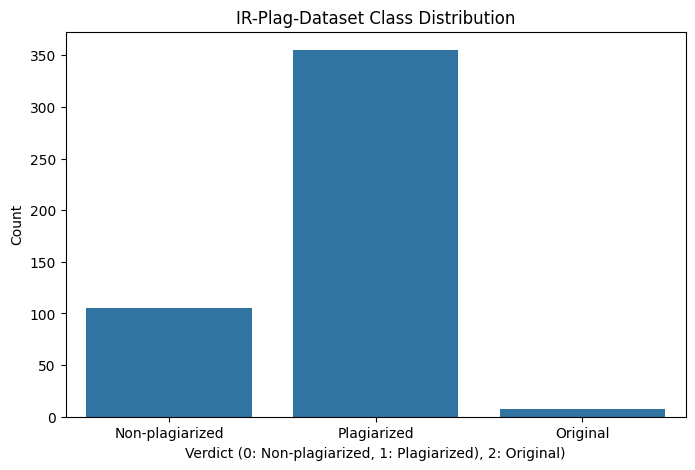

Total Non-plagiarized: 105
Total Plagiarized: 355


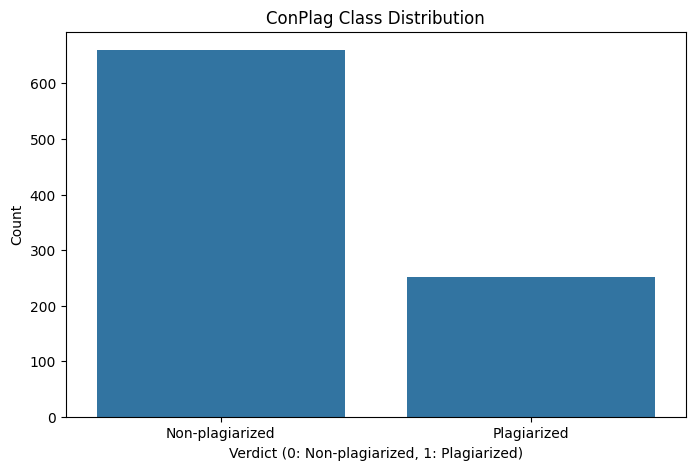

Total Plagiarized: 251 | Total Non-plagiarized: 660


In [5]:
# ver cantidad de plagios y no plagios en los datasets en graficas de barras

def plot_class_distribution(df, title):
    plt.figure(figsize=(8, 5))
    sns.countplot(x='type', data=df)
    plt.title(title)
    plt.ylabel('Count')
    plt.xlabel('Verdict (0: Non-plagiarized, 1: Plagiarized), 2: Original)')
    plt.xticks(ticks=[0, 1, 2], labels=['Non-plagiarized', 'Plagiarized', 'Original'])
    plt.show()
    print(f"Total Non-plagiarized: {df['type'].value_counts().get(0, 0)}")
    print(f"Total Plagiarized: {df['type'].value_counts().get(1, 0)}")

plot_class_distribution(ir_plag_dataset, 'IR-Plag-Dataset Class Distribution')
# Para ConPlag, usar la columna 'verdict' en vez de 'type'


def plot_conplag_distribution(df, title):
    total = train_pairs['verdict'].value_counts() + test_pairs['verdict'].value_counts()
    total = total.reindex([0, 1], fill_value=0)  # Asegurar que ambos valores estén presentes
    plt.figure(figsize=(8, 5))
    sns.barplot(x=total.index, y=total.values)
    plt.title(title)
    plt.xlabel('Verdict (0: Non-plagiarized, 1: Plagiarized)')
    plt.ylabel('Count')
    plt.xticks(ticks=[0, 1], labels=['Non-plagiarized', 'Plagiarized'])
    plt.show()
    print(f"Total Plagiarized: {total.get(1, 0)} | Total Non-plagiarized: {total.get(0, 0)}")
 

plot_conplag_distribution(conPlagCodes, 'ConPlag Class Distribution')

Estos valores no me agradan nada. Reviasré en linea si es verdad que está tan desbalanceado el dataset
y registraré mis resultados aqui

ConPlag:
- Plagio: 251
- No Plagio: 660



IR-Plag:
- Plagio: 355
- No Plagio: 105 + 7 (7 son los que no tienen etiqueta porque son los orignales)

Ahora si, todo tiene sentido. Los datasets están desbalanceados pero si se juntaran, sería un enorme dataset balancedo.

In [6]:
# Configuración mejorada basada en Karnalim (2020) y Fu et al. (2017)
CRITICAL_TOKENS = {
    # Identificadores (conservamos tipo pero normalizamos nombres)
    'IDENTIFIER': lambda t: f'VAR_{t.text[0]}_{len(t.text)}',  # Ej: VAR_x_3
    
    # Literales
    'DECIMAL_LITERAL': lambda t: 'LIT_NUM',
    'STRING_LITERAL': lambda t: 'LIT_STR',
    
    # Operadores
    'EQUAL': lambda t: 'OP_=',
    'NOTEQUAL': lambda t: 'OP_!=',
    'LT': lambda t: 'OP_<',
    'GT': lambda t: 'OP_>',
    'ADD': lambda t: 'OP_+',
    'SUB': lambda t: 'OP_-',
    
    # Estructuras de control
    'IF': lambda t: 'CTRL_if',
    'FOR': lambda t: 'CTRL_for',
    'WHILE': lambda t: 'CTRL_while'
}

# Tokens a ignorar (basado en WASTK)
IGNORE_TOKENS = {
    ';', '(', ')', '[', ']', '{', '}', '@', 'import', 'package'
}

def tokenize_java(code):
    """Tokenizador mejorado con normalización selectiva"""
    input_stream = InputStream(code)
    lexer = JavaLexer(input_stream)
    stream = CommonTokenStream(lexer)
    stream.fill()
    
    tokens = []
    for token in stream.tokens:
        if token.channel != Lexer.DEFAULT_TOKEN_CHANNEL:
            continue
            
        token_name = lexer.symbolicNames[token.type]
        token_text = token.text.strip()
        
     
        if token_name in CRITICAL_TOKENS:
            processed = CRITICAL_TOKENS[token_name](token)
            tokens.append(processed)
        else:
            # Conservamos otros tokens relevantes
            if len(token_text) > 1:  # Ignorar caracteres sueltos
                tokens.append(token_text)
    
    return tokens

def compute_tfidf_similarity(code1, code2):
    # Tokenización mejorada
    tokens1 = tokenize_java(code1)
    tokens2 = tokenize_java(code2)
    
    if not tokens1 or not tokens2:
        return 0.0
    
    # Usamos los tokens directamente como palabras
    doc1 = ' '.join(tokens1)
    doc2 = ' '.join(tokens2)
    
    # Configuración optimizada para código (Karnalim 2020)
    vectorizer = TfidfVectorizer(
        analyzer='word',
        token_pattern=r'\b\w+\b',
        ngram_range=(1, 3),  # Considerar n-grams (Fu et al. 2017)
        min_df=1,
        max_df=0.85,  # Más estricto que texto normal
        sublinear_tf=True  # Suavizar frecuencia
    )
    
    try:
        tfidf_matrix = vectorizer.fit_transform([doc1, doc2])
        similarity = cosine_similarity(tfidf_matrix[0:1], tfidf_matrix[1:2])[0][0]
        return similarity
        
    except Exception as e:
        print(f"Error: {str(e)}")
        return 0.0

In [7]:
# TF-IDF function
def compute_tfidf_similarity(code1, code2):
    # Tokenizar y preprocesar los códigos
    tokens1 = tokenize_java(code1)
    tokens2 = tokenize_java(code2)

    # Vectorizar los códigos
    vectorizer = TfidfVectorizer()
    tfidf_matrix = vectorizer.fit_transform([' '.join(tokens1), ' '.join(tokens2)])

    # Calcular la similitud coseno
    similarity = cosine_similarity(tfidf_matrix[0:1], tfidf_matrix[1:2])
    
    return similarity[0][0] 

conplag = compute_tfidf_similarity(conPlagCodes['code1'][0], conPlagCodes['code2'][0])

# Mostrar similitudes
print(f"Similitud ConPlag: {conplag:.4f}")


Similitud ConPlag: 0.8449


In [8]:

# Función mejorada para calcular similitudes para todos los pares
def calculate_all_similarities(pairs_df):
    similarities = []
    for idx, row in pairs_df.iterrows():
        try:
            sim = compute_tfidf_similarity(row['code1'], row['code2'])
            similarities.append(sim)
        except Exception as e:
            print(f"Error procesando par {row['pair']}: {str(e)}")
            similarities.append(0)
    return np.array(similarities)

Threshold óptimo: 0.81, F1-score: 0.65


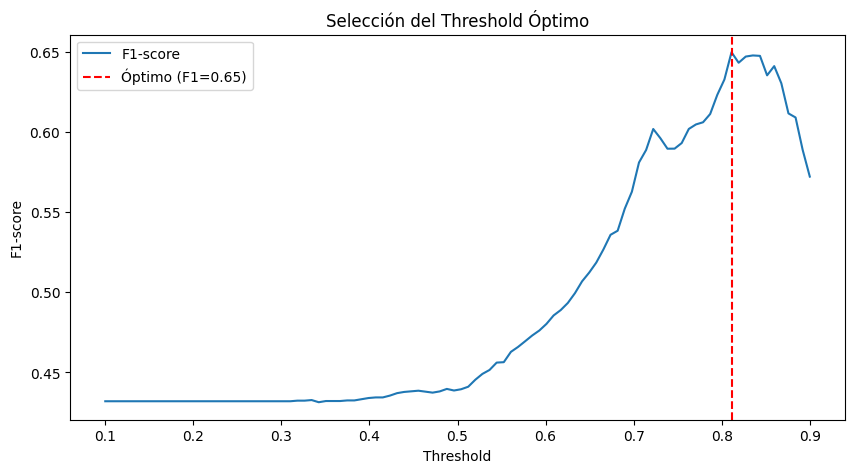

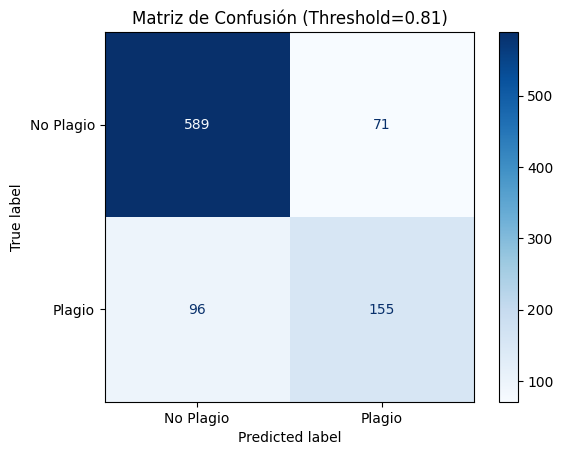

No Plagio: 685, Plagio: 226

Reporte de Clasificación:
              precision    recall  f1-score   support

           0       0.86      0.89      0.88       660
           1       0.69      0.62      0.65       251

    accuracy                           0.82       911
   macro avg       0.77      0.75      0.76       911
weighted avg       0.81      0.82      0.81       911



In [9]:
# Calcular similitudes para ConPlag
conPlagCodes['similarity'] = calculate_all_similarities(conPlagCodes)

# Preparar etiquetas verdaderas (y_true)
y_true = conPlagCodes['verdict'].values

# Calcular threshold óptimo
thresholds = np.linspace(0.1, 0.9, 100)
f1_scores = [f1_score(y_true, conPlagCodes['similarity'] > t) for t in thresholds]
best_threshold = thresholds[np.argmax(f1_scores)]
best_f1 = max(f1_scores)

print(f"Threshold óptimo: {best_threshold:.2f}, F1-score: {best_f1:.2f}")

# Visualización
plt.figure(figsize=(10, 5))
plt.plot(thresholds, f1_scores, label='F1-score')
# Prueba de otros thresholds
#best_threshold = 0.67
plt.axvline(best_threshold, color='r', linestyle='--', label=f'Óptimo (F1={best_f1:.2f})')
plt.xlabel('Threshold')
plt.ylabel('F1-score')
plt.title('Selección del Threshold Óptimo')
plt.legend()
plt.show()




# Matriz de confusión con el threshold óptimo
#best_threshold = 0.67
y_pred = (conPlagCodes['similarity'] > best_threshold).astype(int)
ConfusionMatrixDisplay.from_predictions(y_true, y_pred, display_labels=['No Plagio', 'Plagio'], 
                                        cmap=plt.cm.Blues) 
plt.title(f'Matriz de Confusión (Threshold={best_threshold:.2f})')
plt.show()

print(f'No Plagio: {np.sum(y_pred == 0)}, Plagio: {np.sum(y_pred == 1)}')

# Reporte de clasificación
print("\nReporte de Clasificación:")
print(classification_report(y_true, y_pred))



Generando par: orig0 con plg0
Generando par: orig0 con plg1
Generando par: orig0 con plg2
Generando par: orig0 con plg3
Generando par: orig0 con plg4
Generando par: orig0 con plg5
Generando par: orig0 con plg6
Generando par: orig0 con plg7
Generando par: orig0 con plg8
Generando par: orig0 con plg9
Generando par: orig0 con plg10
Generando par: orig0 con plg11
Generando par: orig0 con plg12
Generando par: orig0 con plg13
Generando par: orig0 con plg14
Generando par: orig0 con plg15
Generando par: orig0 con plg16
Generando par: orig0 con plg17
Generando par: orig0 con plg18
Generando par: orig0 con plg19
Generando par: orig0 con plg20
Generando par: orig0 con plg21
Generando par: orig0 con plg22
Generando par: orig0 con plg23
Generando par: orig0 con plg24
Generando par: orig0 con plg25
Generando par: orig0 con plg26
Generando par: orig0 con plg27
Generando par: orig0 con plg28
Generando par: orig0 con plg29
Generando par: orig0 con plg30
Generando par: orig0 con plg31
Generando par: ori

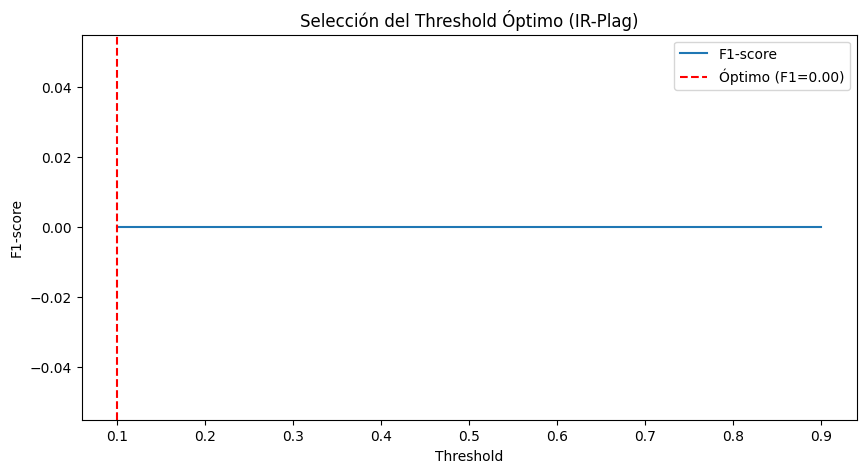

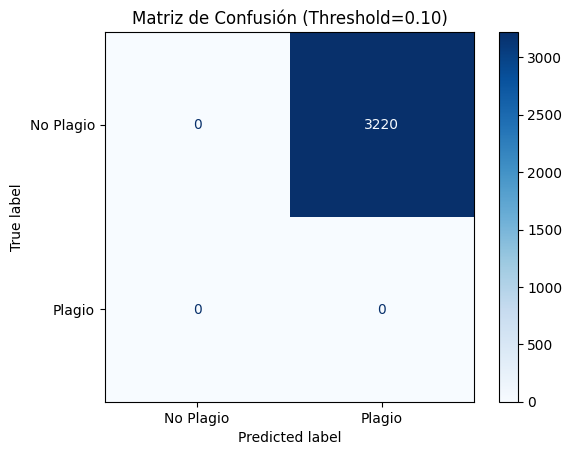

No Plagio: 0, Plagio: 3220

Reporte de Clasificación:
              precision    recall  f1-score   support

   No Plagio       0.00      0.00      0.00    3220.0
      Plagio       0.00      0.00      0.00       0.0

    accuracy                           0.00    3220.0
   macro avg       0.00      0.00      0.00    3220.0
weighted avg       0.00      0.00      0.00    3220.0



/opt/miniconda3/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/opt/miniconda3/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/opt/miniconda3/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/opt/miniconda3/lib/python3.12/site-packag

In [10]:
def generar_pares_ir_plag(df):
    originals = df[df['type'] == 2].reset_index(drop=True)
    plagios = df[df['type'] == 1].reset_index(drop=True)
    no_plagios = df[df['type'] == 0].reset_index(drop=True)

    pares = []

    for orig in originals.itertuples():
        # Pares plagio
        for plg in plagios.itertuples():
            print(f"Generando par: orig{orig.Index} con plg{plg.Index}")
            pares.append({
                'pair': f'orig{orig.Index}_plg{plg.Index}',
                'code1': orig.code,
                'code2': plg.code,
                'verdict': 1
            })
        # Pares no-plagio
        for np in no_plagios.itertuples():
            print(f"Generando par: orig{orig.Index} con np{np.Index}")
            pares.append({
                'pair': f'orig{orig.Index}_np{np.Index}',
                'code1': orig.code,
                'code2': np.code,
                'verdict': 0
            })

    return pd.DataFrame(pares)

# Generar y revisar
ir_pairs = generar_pares_ir_plag(ir_plag_dataset)
print( ir_pairs.head())

ir_pairs['similarity'] = calculate_all_similarities(ir_pairs)

y_true_bin = (ir_pairs['verdict'] == 'plagio').astype(int)

thresholds = np.linspace(0.1, 0.9, 100)
f1_scores = [f1_score(y_true_bin, ir_pairs['similarity'] > t) for t in thresholds]
best_threshold = thresholds[np.argmax(f1_scores)]
best_f1 = max(f1_scores)

print(f"Threshold óptimo IR-Plag: {best_threshold:.2f}, F1-score: {best_f1:.2f}")

# Paso 5: Visualización del F1-score
plt.figure(figsize=(10, 5))
plt.plot(thresholds, f1_scores, label='F1-score')
plt.axvline(best_threshold, color='r', linestyle='--', label=f'Óptimo (F1={best_f1:.2f})')
plt.xlabel('Threshold')
plt.ylabel('F1-score')
plt.title('Selección del Threshold Óptimo (IR-Plag)')
plt.legend()
plt.show()

# Paso 6: Evaluación final
y_pred = (ir_pairs['similarity'] > best_threshold).astype(int)

# Matriz de confusión
ConfusionMatrixDisplay.from_predictions(
    y_true_bin, y_pred, display_labels=['No Plagio', 'Plagio'], cmap=plt.cm.Blues
)
plt.title(f'Matriz de Confusión (Threshold={best_threshold:.2f})')
plt.show()

# Conteo de predicciones
print(f'No Plagio: {np.sum(y_pred == 0)}, Plagio: {np.sum(y_pred == 1)}')

# Reporte de clasificación
print("\nReporte de Clasificación:")
print(classification_report(y_true_bin, y_pred, target_names=["No Plagio", "Plagio"]))
